# Getting Started
Let's begin by getting familiar with some of the relevant algorithms and datasets that we could use in the paper.
- [ ] Find several classic timeseries datasets: sunspots, stock prices, streamflow from the Mississippi River would all be fine, but bonus points if you find (or simulate) something more humerous.
- [ ] Try out several seasonal trend decompositions: STL, STR as example
- [ ] Try out fft and clipping out different `bands` from the frequency domain
- [ ] Put those pieces together to define a function for STF: seasonal-trend decomposition using the Fast-Fourier transform.

Good luck!

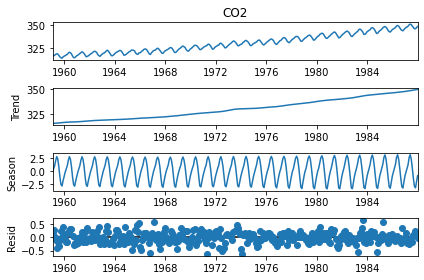

In [359]:
# https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html
import pandas as pd
from statsmodels.tsa.seasonal import STL
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

co2 =pd.read_csv('../data/co2.csv', index_col='date', parse_dates=True, squeeze=True)

stl = STL(co2, seasonal=13)
res = stl.fit()
fig = res.plot()

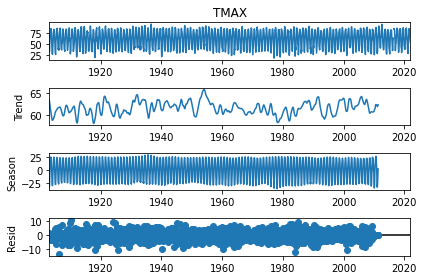

In [360]:
# Load in daily temperature data from station USC00118740
champaignTemp = pd.read_csv('../data/champaign_temps.csv', index_col='date', parse_dates=True, squeeze=True)

# Aggregate to find average max and min temperatures by month
champaignTemp = champaignTemp.resample('M').mean()

# STL on TMAX
stl = STL(champaignTemp["TMAX"])
res = stl.fit()
fig = res.plot()

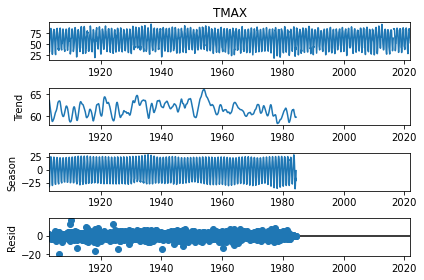

In [361]:
# STL on TMAX with robust = True
stl = STL(champaignTemp["TMAX"], robust = True)
res = stl.fit()
fig = res.plot()

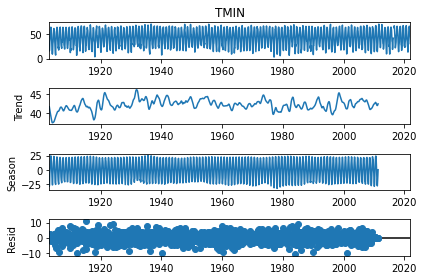

In [362]:
# STL on TMIN
stl = STL(champaignTemp["TMIN"])
res = stl.fit()
fig = res.plot()

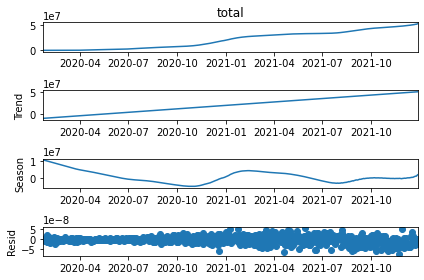

In [363]:
# STL on covid dataset

# Data cleaning
covid = pd.read_csv('../data/time_series_covid19_confirmed_US.csv', parse_dates=True, squeeze=True)
covid_dates = covid.iloc[:, 11:]
covid_dates = covid_dates.T
covid_dates["total"] = covid_dates.sum(axis=1)
covid_dates.index = pd.to_datetime(covid_dates.index, format = '%m/%d/%y')

stl = STL(covid_dates["total"], period = 365)
res = stl.fit()
fig = res.plot()




C:\Users\16189\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


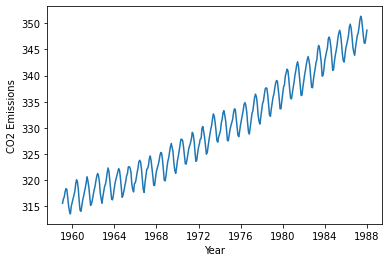

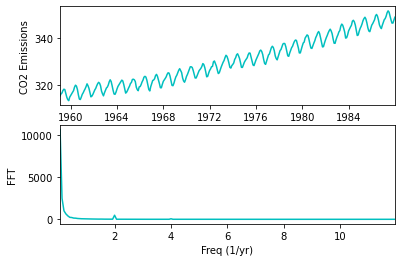

In [388]:
# Tring fft on co2 data
import matplotlib.pyplot as plt
import matplotlib.dates
from datetime import datetime

co2 = pd.read_csv("../data/co2.csv")
co2 =pd.read_csv('../data/co2.csv', parse_dates=True, squeeze=True)
co2["date"] = pd.to_datetime(co2["date"], format = '%Y-%m-%d')
dt = 1 / 12 # yearly freq
t = np.array(co2["date"])
f = np.array(co2["CO2"])
plt.plot(t, f)
plt.xlabel("Year")
plt.ylabel("CO2 Emissions")


n = len(t)
#Compute FFT
fhat = np.fft.fft(f, n)
# Power Spectrum
PSD = fhat * np.conj(fhat) / n
# X axis of freqs
freq = (1 / (dt*n)) * np.arange(n)
# Plotting first half
L = np.arange(1, np.floor(n/2), dtype = 'int')

fig, axes = plt.subplots(2, 1)

plt.sca(axes[0])
plt.plot(t, f, color = 'c', LineWidth = 1.5)
plt.xlim(t[0], t[-1])
plt.xlabel("Year")
plt.ylabel("CO2 Emissions")
plt.sca(axes[1])
plt.plot(freq[L], PSD[L], color = 'c')
plt.xlim(freq[L[0]], freq[L[-1]])
plt.xlabel("Freq (1/yr)")
plt.ylabel("FFT")
plt.show()


C:\Users\16189\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\16189\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\16189\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\16189\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


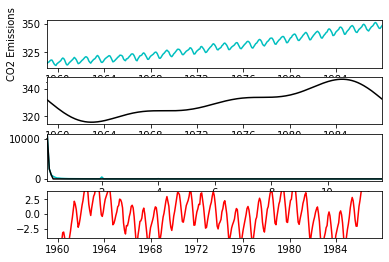

In [389]:
# Use the PSD to filter out noise
# Filter out freqs with low power
indices = PSD > 700
PSDclean = PSD * indices
# Zero out small Fourier coefs
fhat_clean = indices * fhat
# Inverse FFT for filtered time signal
ffilt = np.fft.ifft(fhat_clean)


# Filter out freqs with high power
indices_seasonal = PSD < 700
PSD_seasonal = PSD * indices
fhat_seasonal = indices_seasonal * fhat
ffilt_seasonal = np.fft.ifft(fhat_seasonal)


fig, axes = plt.subplots(4, 1)
plt.sca(axes[0])
plt.plot(t, f, color = 'c')
plt.xlim(t[0], t[-1])
plt.xlabel("Year")
plt.ylabel("CO2 Emissions")


plt.sca(axes[1])
plt.plot(t, ffilt, color = 'k')
plt.xlim(t[0], t[-1])


plt.sca(axes[2])
plt.plot(freq[L], PSD[L], color = 'c')
plt.plot(freq[L], PSDclean[L], color = 'k')
plt.xlim(freq[L[0]], freq[L[-1]])

plt.sca(axes[3])
plt.plot(t, ffilt_seasonal, color = "red")
plt.xlim(t[0], t[-1])
plt.ylim(-4, 4)


# Find the residuals 

plt.show()

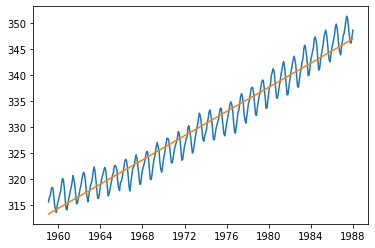

In [366]:
model = LinearRegression()
model.fit(pd.DataFrame(co2["date"].map(datetime.toordinal)), pd.DataFrame(co2["CO2"]))
co2["pred"] = model.predict(pd.DataFrame(co2["date"].map(datetime.toordinal)))
co2["resid"] = co2["CO2"] - co2["pred"]
plt.plot(co2["date"], co2["CO2"])
plt.plot(co2["date"], co2["pred"])

fft_output = np.fft.fft(co2["resid"])
power = np.abs(fft_output)
freq = np.fft.fftfreq(len(co2["resid"]))





